# Q2: *Using linguistic cues, is it possible to detect when betrayal will happen?*

This notebook contains two parts and each part we are using different feature extraction method.
First part we are training 3 simple models:
   - Logistic Regression
   - Random Forest Classifier
   - Gradient Boosting Classifier
   
For the second part we are training same models that are shown above as well as a Fully Connected Linear Network for predicting which season a Diplomacy game will end with betrayal.

In [3]:
import torch
import json
import random
import sklearn
import imblearn
import numpy as np
from io import open
from helpers import *
import torch.nn as nn
import torch.optim as optim
from itertools import product
from collections import Counter
import matplotlib.pyplot as plt
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef,f1_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [4]:
# reading the diplomacy data and setting the random seed so that the notebook can be reproducable.
random.seed(5)
with open("data/diplomacy_data.json", "r") as f:
    diplomacy = json.load(f)

***FIRST PART***

***FEATURE EXTRACTION***

The features are extracted from all the seasons before the last support season and  games are eliminated if they have less than 4 seasons until last support. We are running the models for two sets: Feature set 1(excludes claim and temporal rest) and Feature set 2(includes all of the features).

In [45]:
#Our main feature for our first part in this notebook
#We only consider games which end in a betrayal
betrayal = [entry for entry in diplomacy if entry["betrayal"]==True]
labels = np.empty((0))
victim_items = np.empty((0,12))
betrayer_items = np.empty((0,12))

victim_items_e = np.empty((0,14))
betrayer_items_e = np.empty((0,14))
for who in ["victim","betrayer"]:
    for i,j in zip([0,-3,-2,-1],[-3,-2,-1,None]):
        #We exctract all the features
        item_e = extract_features(betrayal,who,i,j,True)
        #We delete the Claim and Temporal Rest fields
        item = np.delete(item_e, (8,13),axis=0)
        
       
        item = np.transpose(item)
        item_e = np.transpose(item_e)
        
        #Place the features in their corresponding arrays
        if who == "victim":
            victim_items = np.concatenate((victim_items, item), axis=0)
            victim_items_e = np.concatenate((victim_items_e, item_e), axis=0)
        else:
            betrayer_items = np.concatenate((betrayer_items, item), axis=0)
            betrayer_items_e = np.concatenate((betrayer_items_e, item_e), axis=0)
            
        #Create labels for the 4 classes
        if who == "victim":    
            if i == 0:
                labels = np.concatenate((labels, np.repeat(3,item.shape[0])), axis=0) 
            if i == -3:
                labels = np.concatenate((labels, np.repeat(2,item.shape[0])), axis=0)
            if i == -2:
                labels = np.concatenate((labels, np.repeat(1,item.shape[0])), axis=0)
            if i == -1:
                labels = np.concatenate((labels, np.repeat(0,item.shape[0])), axis=0)

In [46]:
#By getting difference between betrayer and victim features we are getting the inbalance features.
#Normalizing the inbalance feateures using scale.
X_train_s = preprocessing.scale(betrayer_items - victim_items)
X_train_e = preprocessing.scale(betrayer_items_e - victim_items_e)
y_train = labels
#Shuffling the dataset
rand_idx = np.random.permutation(len(X_train_s))
X_train_s = X_train_s[rand_idx]
X_train_e = X_train_e[rand_idx]
y_train = y_train[rand_idx]

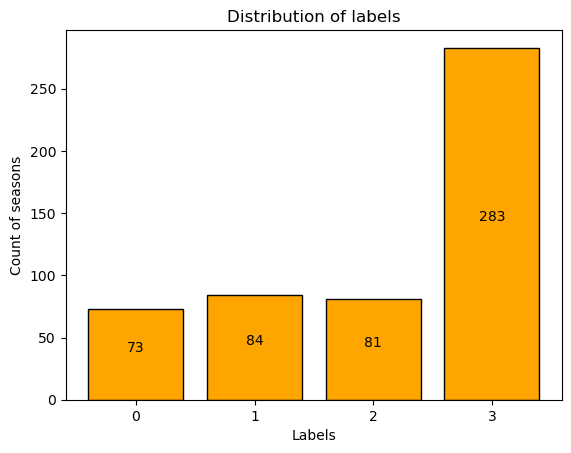

In [47]:
#Ploting the how many features that each class has.
before_1 = Counter(y_train)[0]
before_2 = Counter(y_train)[1]
before_3 = Counter(y_train)[2]
before_4 = Counter(y_train)[3]
x = [0,0.25,0.50,0.75]
y_values = [before_1,before_2,before_3,before_4]
ax = [0,0,0,0]
width=0
for j,y in enumerate(y_values):
    ax[j]=plt.bar(width, y, label='No Betrayal',width=0.2,color='orange',edgecolor="black")
    width+=0.25

plt.xticks(x, ('0', '1','2','3'))
for i in range(4):
    plt.text(ax[i][0].get_x() + ax[i][0].get_width()/2., ax[i][0].get_height()/2,'%d' % int(ax[i][0].get_height()),ha='center', va='bottom')
    
plt.title('Distribution of labels')
plt.xlabel("Labels")
plt.ylabel("Count of seasons")
plt.savefig("qB_imbalance_part1.png")
plt.show()

Form the plot we can see that dataset unbalanced so that while training the models we will balance the data using smote(This library oversample the data at the end we will have same number of each classes and mean and the standard deviation of the class distributions will be the same.)

***BASIC MODELS***

For the basic models everything, except model, will be the same. We used 5 fold cross-validation for the each model and  at the begining of the each cross-validation we used grid search for the finding best parameters with 5-fold cross-validation. So we used nested cross-validations. Moreover we are repeating the same experiment for both including the all features and excluding claim and temporal rest features.

Note: We are not tuning any parameters for the logistic regression so we are not using grid search for it.

- Logistic Regression

In [6]:
# for 5 fold CV with LogisticRegression
#iterate over with and without claim and temporal rest features
for idx,(X_train,y_train)  in enumerate(zip([X_train_s,X_train_e],[y_train,y_train])):
    print(f'With feature set {idx+1}\n-------------------------------')
    #Setting N to 5 means 5-fold cross-validation
    N = 5
    r = np.zeros(N)
    accuracy = np.zeros(N)
    RMSE = np.zeros(N)
    MAE=np.zeros(N)
    
    bet_detection=np.empty((0,4))

    kf = KFold(n_splits=N)
    i=0
    for train_index, test_index in kf.split(X_train):
        #Seperating data as train and validation
        X_tr_fold, X_te_fold = X_train[train_index], X_train[test_index]
        y_tr_fold, y_te_fold = y_train[train_index], y_train[test_index]
        #balancing the training dataset using smote
        oversample = SMOTE()
        X_tr_fold, y_tr_fold = oversample.fit_sample(X_tr_fold, y_tr_fold)
        #shuffling the balanced data
        rand_idx=np.random.permutation(len(X_tr_fold))
        X_tr_fold = X_tr_fold[rand_idx]
        y_tr_fold = y_tr_fold[rand_idx]
         #We are setting our model as logistic regression 
        regressor = LogisticRegression()
        #fitting the data into the model
        regressor.fit(X_tr_fold,np.ravel(y_tr_fold))
        #prediction over the current validation set
        y_predict = regressor.predict(X_te_fold)
        #Calculate f1-score(each class separately)
        bet_detection = np.concatenate((bet_detection,[f1_score(y_te_fold,y_predict,average=None)]),axis=0)
        #Calculate Matthews correlation coefficient for the class 0
        z_window_pred = np.copy(y_predict)
        z_window_pred[z_window_pred !=0] = 1
        z_window_true = np.copy(y_te_fold)
        z_window_true[z_window_true !=0] = 1
        r[i] = matthews_corrcoef(z_window_true, z_window_pred)
        #Calculate rmse and mae for extra information and comparison between models
        RMSE[i] = np.sqrt(sklearn.metrics.mean_squared_error(y_te_fold, y_predict))
        MAE[i] = sklearn.metrics.mean_absolute_error(y_te_fold, y_predict)
        print('i:{}, matthews_corrcoef:{}, f1_score:{}, RMSE:{}, MAE:{}, bet_detection:{}'.format(i, r[i],bet_detection[i,0],RMSE[i], MAE[i],bet_detection[i]))
        i+=1
    #After getting the all results we are printing the best overall result over 5 different fold.
    print('Best results:')
    print(' matthews_corrcoef ={} in i={},\n f1_score={} in i={},\n RMSE={} in i={},\n MAE={} in i={}'.format(np.amax(r), np.argmax(r), np.amax(bet_detection[:,0]), np.argmax(bet_detection[:,0]), np.amin(RMSE), np.argmin(RMSE), np.amin(MAE), np.argmin(MAE)))

With feature set 1
-------------------------------
i:0, matthews_corrcoef:0.16240532485281473, f1_score:0.25641025641025644, RMSE:1.5886502207249789, MAE:1.2476190476190476, bet_detection:[0.25641026 0.2962963  0.25       0.26086957]
i:1, matthews_corrcoef:-0.18301143487743313, f1_score:0.08333333333333333, RMSE:1.8631032838127484, MAE:1.5480769230769231, bet_detection:[0.08333333 0.07142857 0.19607843 0.24691358]
i:2, matthews_corrcoef:-0.04052204492365539, f1_score:0.14285714285714288, RMSE:1.781313257986063, MAE:1.4615384615384615, bet_detection:[0.14285714 0.25       0.16       0.23684211]
i:3, matthews_corrcoef:0.06154574548966637, f1_score:0.2380952380952381, RMSE:1.8527526299245423, MAE:1.5288461538461537, bet_detection:[0.23809524 0.2        0.22857143 0.17283951]
i:4, matthews_corrcoef:0.049882551800475974, f1_score:0.22727272727272724, RMSE:1.7893918176081718, MAE:1.4326923076923077, bet_detection:[0.22727273 0.25       0.3255814  0.19178082]
Best results:
 matthews_corrcoef 

In [7]:
# for 5 fold CV for parameter tuning with RandomForest
#iterate over with and without claim and temporal rest features
for idx,(X_train,y_train)  in enumerate(zip([X_train_s,X_train_e],[y_train,y_train])):
    print(f'With feature set {idx+1}\n-------------------------------')
    #setting the estimator as random forest classifier
    estimator = RandomForestClassifier()
    #setting the parameters which we will use them to tune the parameters and use them in the grid search
    parameters =  {
     'max_depth': [3, 6, 9, 18, 36,72],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [100, 200, 400, 600, 800]}
    #Setting N to 5 means 5-fold cross-validation
    N = 5
    r = np.zeros(N)
    accuracy = np.zeros(N)
    RMSE = np.zeros(N)
    MAE=np.zeros(N)
    bet_detection=np.empty((0,4))

    kf = KFold(n_splits=N)
    i=0


    for train_index, test_index in kf.split(X_train):
        #Seperating data as train and validation
        X_tr_fold, X_te_fold = X_train[train_index], X_train[test_index]
        y_tr_fold, y_te_fold = y_train[train_index], y_train[test_index]
        #balancing the training dataset using smote
        oversample = SMOTE()
        X_tr_fold, y_tr_fold = oversample.fit_sample(X_tr_fold, y_tr_fold)
        #shuffling the balanced data
        rand_idx=np.random.permutation(len(X_tr_fold))
        X_tr_fold = X_tr_fold[rand_idx]
        y_tr_fold = y_tr_fold[rand_idx]
    
        #We are setting the grid search(cv used for cross validation and set as 5 n_jobs=-1 so we will use the all processors available)
        grid_search = GridSearchCV(estimator = estimator, param_grid = parameters, 
                              cv = N, n_jobs = -1)
        #fitting the data into the all sets of parameters
        grid_search.fit(X_tr_fold,np.ravel(y_tr_fold))
        # We are printing the best parameters for the current training set.
        print("Best Parameters for {} fold: {}".format(i,grid_search.best_params_))
        #We are getting the best estimator model
        regressor = grid_search.best_estimator_
        regressor.fit(X_tr_fold,np.ravel(y_tr_fold))# Actually this line is not needed since we are fitting all of the models but for just demosntration we are fitting anyway.
        #prediction over the current validation set
        y_predict = regressor.predict(X_te_fold)
        #Calculate f1-score(each class separately)
        bet_detection = np.concatenate((bet_detection,[f1_score(y_te_fold,y_predict,average=None)]),axis=0)
        #Calculate Matthews correlation coefficient for the class 0
        z_window_pred = np.copy(y_predict)
        z_window_pred[z_window_pred !=0] = 1
        z_window_true = np.copy(y_te_fold)
        z_window_true[z_window_true !=0] = 1
        r[i] = matthews_corrcoef(z_window_true, z_window_pred)
        #Calculate rmse and mae for extra information and comparison between models
        RMSE[i] = np.sqrt(sklearn.metrics.mean_squared_error(y_te_fold, y_predict))
        MAE[i] = sklearn.metrics.mean_absolute_error(y_te_fold, y_predict)
        print('i:{}, matthews_corrcoef:{}, f1_score:{}, RMSE:{}, MAE:{}, bet_detection:{}'.format(i, r[i],bet_detection[i,0],RMSE[i], MAE[i],bet_detection[i]))
        i+=1
    #After getting the all results we are printing the best overall result over 5 different fold.
    print('Best results:')
    print(' matthews_corrcoef ={} in i={},\n f1_score={} in i={},\n RMSE={} in i={},\n MAE={} in i={}'.format(np.amax(r), np.argmax(r), np.amax(bet_detection[:,0]), np.argmax(bet_detection[:,0]), np.amin(RMSE), np.argmin(RMSE), np.amin(MAE), np.argmin(MAE)))

With feature set 1
-------------------------------
Best Parameters for 0 fold: {'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
i:0, matthews_corrcoef:0.075052056099763, f1_score:0.17391304347826086, RMSE:1.4896468101693163, MAE:1.0952380952380953, bet_detection:[0.17391304 0.15789474 0.11111111 0.53097345]
Best Parameters for 1 fold: {'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
i:1, matthews_corrcoef:0.08921633931048109, f1_score:0.23529411764705882, RMSE:1.745874257521693, MAE:1.3173076923076923, bet_detection:[0.23529412 0.06451613 0.08695652 0.5       ]
Best Parameters for 2 fold: {'max_depth': 72, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
i:2, matthews_corrcoef:-0.04550157551932901, f1_score:0.08, RMSE:1.5597090458455087, MAE:1.1634615384615385, bet_detection:[0.08       0.07692308 0.2173913  0.48648649]
Best Parameters for 3 fold: {'max_depth': 72, 'min_samples_leaf': 1, 'min_s

In [8]:
# for 5 fold CV for parameter tuning with GBR
#iterate over with and without claim and temporal rest features
for idx,(X_train,y_train)  in enumerate(zip([X_train_s,X_train_e],[y_train,y_train])):
    print(f'With feature set {idx+1}\n-------------------------------')
    #setting the estimator as gradient boosting classifier
    estimator = GradientBoostingClassifier()
    #setting the parameters which we will use them to tune the parameters and use them in the grid search
    parameters =  {
        'max_depth': [3, 6],
        'min_samples_leaf': [1, 2],
        'min_samples_split': [2, 4],
        'learning_rate' : [0.1,0.01],
        'n_estimators': [100, 200, 400]}
    #Setting N to 5 means 5-fold cross-validation
    N = 5
    r = np.zeros(N)
    accuracy = np.zeros(N)
    RMSE = np.zeros(N)
    MAE=np.zeros(N)
    bet_detection=np.empty((0,4))

    kf = KFold(n_splits=N)
    i=0


    for train_index, test_index in kf.split(X_train):
        #Seperating data as train and validation
        X_tr_fold, X_te_fold = X_train[train_index], X_train[test_index]
        y_tr_fold, y_te_fold = y_train[train_index], y_train[test_index]
        #balancing the training dataset using smote
        oversample = SMOTE()
        X_tr_fold, y_tr_fold = oversample.fit_sample(X_tr_fold, y_tr_fold)
        #shuffling the balanced data
        rand_idx=np.random.permutation(len(X_tr_fold))
        X_tr_fold = X_tr_fold[rand_idx]
        y_tr_fold = y_tr_fold[rand_idx]

        #We are setting the grid search(cv used for cross validation and set as 5 n_jobs=-1 so we will use the all processors available)
        grid_search = GridSearchCV(estimator = estimator, param_grid = parameters, 
                              cv = N, n_jobs = -1)
        #fitting the data into the all sets of parameters
        grid_search.fit(X_tr_fold,np.ravel(y_tr_fold))
        # We are printing the best parameters for the current training set.
        print("Best Parameters for {} fold: {}".format(i,grid_search.best_params_))
        #We are getting the best estimator model
        regressor = grid_search.best_estimator_
        regressor.fit(X_tr_fold,np.ravel(y_tr_fold))# Actually this line is not needed since we are fitting all of the models but for just demosntration we are fitting anyway.
        #prediction over the current validation set
        y_predict = regressor.predict(X_te_fold)
        #Calculate f1-score(each class separately)
        bet_detection = np.concatenate((bet_detection,[f1_score(y_te_fold,y_predict,average=None)]),axis=0)
        #Calculate Matthews correlation coefficient for the class 0
        z_window_pred = np.copy(y_predict)
        z_window_pred[z_window_pred !=0] = 1
        z_window_true = np.copy(y_te_fold)
        z_window_true[z_window_true !=0] = 1
        r[i] = matthews_corrcoef(z_window_true, z_window_pred)
        #Calculate rmse and mae for extra information and comparison between models
        RMSE[i] = np.sqrt(sklearn.metrics.mean_squared_error(y_te_fold, y_predict))
        MAE[i] = sklearn.metrics.mean_absolute_error(y_te_fold, y_predict)
        print('i:{}, matthews_corrcoef:{}, f1_score:{}, RMSE:{}, MAE:{}, bet_detection:{}'.format(i, r[i],bet_detection[i,0],RMSE[i], MAE[i],bet_detection[i]))
        i+=1
    #After getting the all results we are printing the best overall result over 5 different fold.
    print('Best results:')
    print(' matthews_corrcoef ={} in i={},\n f1_score={} in i={},\n RMSE={} in i={},\n MAE={} in i={}'.format(np.amax(r), np.argmax(r), np.amax(bet_detection[:,0]), np.argmax(bet_detection[:,0]), np.amin(RMSE), np.argmin(RMSE), np.amin(MAE), np.argmin(MAE)))

With feature set 1
-------------------------------
Best Parameters for 0 fold: {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 400}
i:0, matthews_corrcoef:0.10089692439079567, f1_score:0.1904761904761905, RMSE:1.5023790657297036, MAE:1.1333333333333333, bet_detection:[0.19047619 0.11428571 0.1        0.49122807]
Best Parameters for 1 fold: {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 200}
i:1, matthews_corrcoef:-0.01497818518107938, f1_score:0.12903225806451615, RMSE:1.6727453252294333, MAE:1.2019230769230769, bet_detection:[0.12903226 0.13333333 0.16666667 0.58536585]
Best Parameters for 2 fold: {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 400}
i:2, matthews_corrcoef:-0.11633501014942219, f1_score:0.0, RMSE:1.4411533842457842, MAE:1.0576923076923077, bet_detection:[0.         0.11428571 0.19047619 0.56880734]
Best Param

***SECOND PART***

***FEATURE EXTRACTION***

We are using the running mean for each season here that is explained in the report with a figure. We are running the models for two sets: Feature set 1(excludes claim and temporal rest) and Feature set 2(includes all of the features).

In [48]:
#This performs the main feature extraction of the notebook.
items = []
victim_items = []
betrayer_items = []
labels = []
whole_items=[]


victim_items_e = []
betrayer_items_e = []
labels = []
whole_items_e=[]
for entry in diplomacy:
    #take the feature if and only if the game ends with betrayal
    if not entry["betrayal"]:
        continue
    before_betrayer = []
    before_victim = []
    
    before_betrayer_e = []
    before_victim_e = []
    seasons = seasons_before_betrayal(entry)
    #We only take games with more than 4 season into account
    if len(seasons) < 4:
        continue
    for i,season in enumerate(seasons):
        #We only consider a season valid if both players sent a message in that season
        if len(season['messages']['victim']) == 0 or len(season['messages']['betrayer']) == 0:
            continue
        if len(seasons) == i+1:
            label_item = 1
        else:
            label_item = 0
        labels.append(label_item)
        #Create the features for victim and the betrayer
        for who in ["victim","betrayer"]:
            #politness
            politness = [message["politeness"] for message in season["messages"][who]]           
            politness_item = np.mean(politness) if len(politness)>=1 else 0
            #sentiment
            positive_sentiment = [message["sentiment"]["positive"] for message in season["messages"][who]]
            negative_sentiment = [message["sentiment"]["negative"] for message in season["messages"][who]]
            neutral_sentiment = [message["sentiment"]["neutral"] for message in season["messages"][who]]
            positive_item = np.mean(positive_sentiment) if len(positive_sentiment)>=1 else 0
            negative_item = np.mean(negative_sentiment) if len(negative_sentiment)>=1 else 0
            neutral_item = np.mean(neutral_sentiment) if len(neutral_sentiment)>=1 else 0
            #nb_requests
            nb_requests = [message["n_requests"] for message in season["messages"][who]]
            requests_item = np.mean(nb_requests) if len(nb_requests)>=1 else 0
            #nb_words
            nb_words = [message["n_words"] for message in season["messages"][who]]
            words_item = np.mean(nb_words) if len(nb_words)>=1 else 0
            #nb_sentences
            nb_sentences = [message["n_sentences"] for message in season["messages"][who]]
            sentences_item = np.mean(nb_sentences) if len(nb_sentences)>=1 else 0
            #premise
            premise = [len(message["lexicon_words"]["premise"]) for message in season["messages"][who] if "premise" in message["lexicon_words"].keys()]
            premise_item = np.mean(premise) if len(premise)>=1 else 0
            #claim
            claim = [len(message["lexicon_words"]["claim"]) for message in season["messages"][who] if "claim" in message["lexicon_words"].keys()]
            claim_item = np.mean(claim) if len(claim)>=1 else 0
            #disc_comparison
            disc_comparison = [len(message["lexicon_words"]["disc_comparison"]) for message in season["messages"][who] if "disc_comparison" in message["lexicon_words"].keys()]
            comparison_item = np.mean(disc_comparison) if len(disc_comparison)>=1 else 0
            #disc_expansion
            disc_expansion = [len(message["lexicon_words"]["disc_expansion"]) for message in season["messages"][who] if "disc_expansion" in message["lexicon_words"].keys()]
            expansion_item = np.mean(disc_expansion) if len(disc_expansion)>=1 else 0
            #disc_contingency
            disc_contingency = [len(message["lexicon_words"]["disc_contingency"]) for message in season["messages"][who] if "disc_contingency" in message["lexicon_words"].keys()]
            contingency_item = np.mean(disc_contingency) if len(disc_contingency)>=1 else 0
            #disc_temporal_future
            disc_temporal_future = [len(message["lexicon_words"]["disc_temporal_future"]) for message in season["messages"][who] if "disc_temporal_future" in message["lexicon_words"].keys()]
            temporal_future_item = np.mean(disc_temporal_future) if len(disc_temporal_future)>=1 else 0
            #disc_temporal_rest
            disc_temporal_rest = [len(message["lexicon_words"]["disc_temporal_rest"]) for message in season["messages"][who] if "disc_temporal_rest" in message["lexicon_words"].keys()]
            temporal_rest_item = np.mean(disc_temporal_rest) if len(disc_temporal_rest)>=1 else 0
            
            
            item_e = [politness_item,positive_item,negative_item,neutral_item,requests_item,words_item,sentences_item,\
                premise_item,claim_item,comparison_item,expansion_item,contingency_item,temporal_future_item,temporal_rest_item]
            
            #we exclude Claim and Temporal rest for some of our models
            item = np.delete(item_e, (8,13),axis=0)
            
            #We take the mean of each feature for each each
            if who == "victim":
                before_victim.append(item)
                victim_items.append(np.mean(before_victim, axis = 0))
                
                before_victim_e.append(item_e)
                victim_items_e.append(np.mean(before_victim_e, axis = 0))
            else:
                before_betrayer.append(item)
                betrayer_items.append(np.mean(before_betrayer, axis = 0))
                
                before_betrayer_e.append(item_e)
                betrayer_items_e.append(np.mean(before_betrayer_e, axis = 0))
                
        whole_items.append(np.sum([victim_items[-1],betrayer_items[-1]], axis = 0)/2)
        whole_items_e.append(np.sum([victim_items_e[-1],betrayer_items_e[-1]], axis = 0)/2)
                
victim_items = np.array(victim_items)
betrayer_items = np.array(betrayer_items)
whole_items = np.array(whole_items)

victim_items_e = np.array(victim_items_e)
betrayer_items_e = np.array(betrayer_items_e)
whole_items_e = np.array(whole_items_e)

labels = np.array(labels)

***BASIC MODELS***

For the basic models everything, except model, will be the same. We used 5 fold cross-validation for the each model and  at the begining of the each cross-validation we used grid search for the finding best parameters with 5-fold cross-validation. So we used nested cross-validations. Moreover we are repeating the same experiment for both including the all features and excluding claim and temporal rest features.

Note: We are not tuning any parameters for the logistic regression so we are not using grid search for it.

In [49]:
#By getting difference between betrayer and victim features we are getting the inbalance features.
#Normalizing the inbalance feateures using scale.
X_train_s = preprocessing.scale(betrayer_items - victim_items)
X_train_e = preprocessing.scale(betrayer_items_e - victim_items_e)
y_train = labels
#Shuffling the dataset
rand_idx = np.random.permutation(len(X_train_s))
X_train_s = X_train_s[rand_idx]
X_train_e = X_train_e[rand_idx]
y_train = y_train[rand_idx]

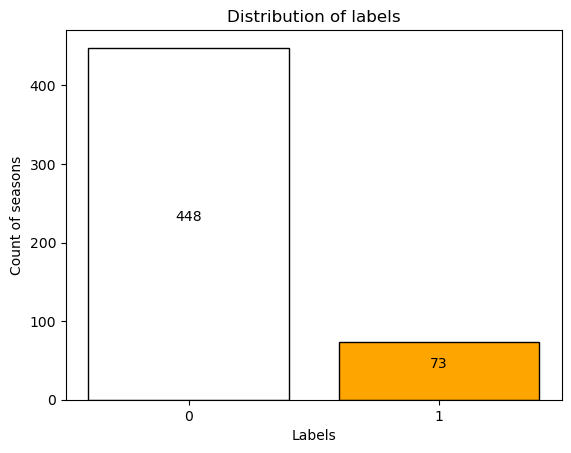

In [50]:
#Ploting the how many features that each class has.
width = 0.1
x=[0,0.25]
zeros = plt.bar(0, Counter(y_train)[0], label='No Betrayal',width=0.2,color='white',edgecolor="black")
ones = plt.bar(0.25,Counter(y_train)[1] , label='Betrayal',width=0.2,color='orange',edgecolor="black")
plt.text(zeros[0].get_x() + zeros[0].get_width()/2., zeros[0].get_height()/2,'%d' % int(zeros[0].get_height()),ha='center', va='bottom')
plt.text(ones[0].get_x() + ones[0].get_width()/2., ones[0].get_height()/2,'%d' % int(ones[0].get_height()),ha='center', va='bottom')
plt.xticks(x, ('0', '1'))

plt.title('Distribution of labels')
plt.xlabel("Labels")
plt.ylabel("Count of seasons")
plt.savefig("qB_imbalance_part2.png")
plt.show()

In [12]:
# for 5 fold CV with LogisticRegression
#iterate over with and without claim and temporal rest features
for idx,(X_train,y_train)  in enumerate(zip([X_train_s,X_train_e],[y_train,y_train])):
    print(f'With feature set {idx+1}\n-------------------------------')
    #Setting N to 5 means 5-fold cross-validation
    N = 5
    r = np.zeros(N)
    accuracy = np.zeros(N)
    RMSE = np.zeros(N)
    MAE=np.zeros(N)
    f1_scores=np.zeros(N)

    kf = KFold(n_splits=N)
    i=0
    for train_index, test_index in kf.split(X_train):
        #Seperating data as train and validation
        X_tr_fold, X_te_fold = X_train[train_index], X_train[test_index]
        y_tr_fold, y_te_fold = y_train[train_index], y_train[test_index]
        #balancing the training dataset using smote
        oversample = SMOTE()
        X_tr_fold, y_tr_fold = oversample.fit_sample(X_tr_fold, y_tr_fold)
        #shuffling the balanced data
        rand_idx=np.random.permutation(len(X_tr_fold))
        X_tr_fold = X_tr_fold[rand_idx]
        y_tr_fold = y_tr_fold[rand_idx]
        #We are setting our model as logistic regression 
        regressor = LogisticRegression()
        #fitting the data into the model
        regressor.fit(X_tr_fold,np.ravel(y_tr_fold))
        #prediction over the current validation set
        y_predict = regressor.predict(X_te_fold)
        #Calculate f1-score, accuracy, Matthews correlation coefficient
        f1_scores[i] = f1_score(y_te_fold,y_predict)
        accuracy[i] = regressor.score(X_te_fold,y_te_fold)
        r[i] = matthews_corrcoef(y_te_fold, y_predict)
        #Calculate rmse and mae for extra information and comparison between models
        RMSE[i] = np.sqrt(sklearn.metrics.mean_squared_error(y_te_fold, y_predict))
        MAE[i] = sklearn.metrics.mean_absolute_error(y_te_fold, y_predict)
        print('i:{}, matthews_corrcoef:{}, accuracy:{}, RMSE:{}, MAE:{},f1_score:{}'.format(i, r[i],accuracy[i],RMSE[i], MAE[i], f1_scores[i]))
        i+=1
    #After getting the all results we are printing the best overall result over 5 different fold.
    print('Best results:')
    print(' matthews_corrcoef ={} in i={},\n accuracy={} in i={},\n RMSE={} in i={},\n MAE={} in i={},\n f1_score={} in i={} '.format(np.amax(r), np.argmax(r), np.amax(accuracy), np.argmax(accuracy), np.amin(RMSE), np.argmin(RMSE), np.amin(MAE), np.argmin(MAE),np.amax(f1_scores), np.argmax(f1_scores)))

With feature set 1
-------------------------------
i:0, matthews_corrcoef:0.06119900613621045, accuracy:0.5714285714285714, RMSE:0.6546536707079771, MAE:0.42857142857142855,f1_score:0.26229508196721313
i:1, matthews_corrcoef:-0.08259308406823933, accuracy:0.5, RMSE:0.7071067811865476, MAE:0.5,f1_score:0.16129032258064516
i:2, matthews_corrcoef:-0.02180967590080987, accuracy:0.5, RMSE:0.7071067811865476, MAE:0.5,f1_score:0.1875
i:3, matthews_corrcoef:-0.050677591680696285, accuracy:0.5096153846153846, RMSE:0.7002746713858894, MAE:0.49038461538461536,f1_score:0.19047619047619047
i:4, matthews_corrcoef:0.06715474916917052, accuracy:0.5576923076923077, RMSE:0.6650621717611762, MAE:0.4423076923076923,f1_score:0.25806451612903225
Best results:
 matthews_corrcoef =0.06715474916917052 in i=4,
 accuracy=0.5714285714285714 in i=0,
 RMSE=0.6546536707079771 in i=0,
 MAE=0.42857142857142855 in i=0,
 f1_score=0.26229508196721313 in i=0 
With feature set 2
-------------------------------
i:0, matthew

In [13]:
# for 5 fold CV for parameter tuning with RandomForest
#iterate over with and without claim and temporal rest features
for idx,(X_train,y_train)  in enumerate(zip([X_train_s,X_train_e],[y_train,y_train])):
    print(f'With feature set {idx+1}\n-------------------------------')
    #setting the estimator as random forest classifier
    estimator = RandomForestClassifier()
    #setting the parameters which we will use them to tune the parameters and use them in the grid search
    parameters =  {
        'max_depth': [3, 6, 9, 18],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [100, 200, 400, 600, 800]}
    #Setting N to 5 means 5-fold cross-validation
    N = 5
    r = np.zeros(N)
    accuracy = np.zeros(N)
    RMSE = np.zeros(N)
    MAE=np.zeros(N)
    f1_scores=np.zeros(N)


    kf = KFold(n_splits=N)
    i=0
    for train_index, test_index in kf.split(X_train):
        #Seperating data as train and validation
        X_tr_fold, X_te_fold = X_train[train_index], X_train[test_index]
        y_tr_fold, y_te_fold = y_train[train_index], y_train[test_index]
        #balancing the training dataset using smote
        oversample = SMOTE()
        X_tr_fold, y_tr_fold = oversample.fit_sample(X_tr_fold, y_tr_fold)
        #shuffling the balanced data
        rand_idx=np.random.permutation(len(X_tr_fold))
        X_tr_fold = X_tr_fold[rand_idx]
        y_tr_fold = y_tr_fold[rand_idx]
        
        #We are setting the grid search(cv used for cross validation and set as 5 n_jobs=-1 so we will use the all processors available)
        grid_search = GridSearchCV(estimator = estimator, param_grid = parameters, 
                              cv = N, n_jobs = -1)
        #fitting the data into the all sets of parameters
        grid_search.fit(X_tr_fold,np.ravel(y_tr_fold))
        # We are printing the best parameters for the current training set.
        print("Best Parameters for {} fold: {}".format(i,grid_search.best_params_))
        #We are getting the best estimator model
        regressor = grid_search.best_estimator_
        regressor.fit(X_tr_fold,np.ravel(y_tr_fold)) # Actually this line is not needed since we are fitting all of the models but for just demosntration we are fitting anyway.
        #prediction over the current validation set
        y_predict = regressor.predict(X_te_fold)
        #Calculate f1-score, accuracy, Matthews correlation coefficient
        f1_scores[i] = f1_score(y_te_fold,y_predict)
        accuracy[i] = regressor.score(X_te_fold,y_te_fold)
        r[i] = matthews_corrcoef(y_te_fold, y_predict)
        #Calculate rmse and mae for extra information and comparison between models
        RMSE[i] = np.sqrt(sklearn.metrics.mean_squared_error(y_te_fold, y_predict))
        MAE[i] = sklearn.metrics.mean_absolute_error(y_te_fold, y_predict)
        print('i:{}, matthews_corrcoef:{}, accuracy:{}, RMSE:{}, MAE:{},f1_score:{}'.format(i, r[i],accuracy[i],RMSE[i], MAE[i], f1_scores[i]))
        i+=1
    #After getting the all results we are printing the best overall result over 5 different fold.
    print('Best results:')
    print(' matthews_corrcoef ={} in i={},\n accuracy={} in i={},\n RMSE={} in i={},\n MAE={} in i={},\n f1_score={} in i={} '.format(np.amax(r), np.argmax(r), np.amax(accuracy), np.argmax(accuracy), np.amin(RMSE), np.argmin(RMSE), np.amin(MAE), np.argmin(MAE),np.amax(f1_scores), np.argmax(f1_scores)))

With feature set 1
-------------------------------
Best Parameters for 0 fold: {'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
i:0, matthews_corrcoef:-0.12254630365216752, accuracy:0.6952380952380952, RMSE:0.5520524474738834, MAE:0.3047619047619048,f1_score:0.058823529411764705
Best Parameters for 1 fold: {'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
i:1, matthews_corrcoef:-0.03150517713606188, accuracy:0.7307692307692307, RMSE:0.5188745216627708, MAE:0.2692307692307692,f1_score:0.125
Best Parameters for 2 fold: {'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
i:2, matthews_corrcoef:-0.009828039493309125, accuracy:0.75, RMSE:0.5, MAE:0.25,f1_score:0.13333333333333333
Best Parameters for 3 fold: {'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
i:3, matthews_corrcoef:0.0651685393258427, accuracy:0.7692307692307693, RMSE:0.4803844614152614

In [15]:
# for 5 fold CV for parameter tuning with GBR
#iterate over with and without claim and temporal rest features
for idx,(X_train,y_train)  in enumerate(zip([X_train_s,X_train_e],[y_train,y_train])):
    print(f'With feature set {idx+1}\n-------------------------------')
    #setting the estimator as gradient boosting classifier
    estimator = GradientBoostingClassifier()
    #setting the parameters which we will use them to tune the parameters and use them in the grid search
    parameters =  {
        'max_depth': [3, 6],
        'min_samples_leaf': [1, 2],
        'min_samples_split': [2, 4],
        'learning_rate' : [0.1,0.01],
        'n_estimators': [100, 200, 400]}
    #Setting N to 5 means 5-fold cross-validation
    N = 5
    r = np.zeros(N)
    accuracy = np.zeros(N)
    RMSE = np.zeros(N)
    MAE=np.zeros(N)
    f1_scores=np.zeros(N)

    kf = KFold(n_splits=N)
    i=0

    for train_index, test_index in kf.split(X_train):
        #Seperating data as train and validation
        X_tr_fold, X_te_fold = X_train[train_index], X_train[test_index]
        y_tr_fold, y_te_fold = y_train[train_index], y_train[test_index]
        #balancing the training dataset using smote
        oversample = SMOTE()
        X_tr_fold, y_tr_fold = oversample.fit_sample(X_tr_fold, y_tr_fold)
        #shuffling the balanced data
        rand_idx=np.random.permutation(len(X_tr_fold))
        X_tr_fold = X_tr_fold[rand_idx]
        y_tr_fold = y_tr_fold[rand_idx]

        #We are setting the grid search(cv used for cross validation and set as 5 n_jobs=-1 so we will use the all processors available)
        grid_search = GridSearchCV(estimator = estimator, param_grid = parameters, 
                              cv = N, n_jobs = -1)
        #fitting the data into the all sets of parameters
        grid_search.fit(X_tr_fold,np.ravel(y_tr_fold))
        # We are printing the best parameters for the current training set.
        print("Best Parameters for {} fold: {}".format(i,grid_search.best_params_))
        #We are getting the best estimator model
        regressor = grid_search.best_estimator_
        regressor.fit(X_tr_fold,np.ravel(y_tr_fold)) # Actually this line is not needed since we are fitting all of the models but for just demosntration we are fitting anyway.
        #prediction over the current validation set
        y_predict = regressor.predict(X_te_fold)
        #Calculate f1-score, accuracy, Matthews correlation coefficient
        f1_scores[i] = f1_score(y_te_fold,y_predict)
        accuracy[i] = regressor.score(X_te_fold,y_te_fold)
        r[i] = matthews_corrcoef(y_te_fold, y_predict)
        #Calculate rmse and mae for extra information and comparison between models
        RMSE[i] = np.sqrt(sklearn.metrics.mean_squared_error(y_te_fold, y_predict))
        MAE[i] = sklearn.metrics.mean_absolute_error(y_te_fold, y_predict)
        print('i:{}, matthews_corrcoef:{}, accuracy:{}, RMSE:{}, MAE:{},f1_score:{}'.format(i, r[i],accuracy[i],RMSE[i], MAE[i], f1_scores[i]))
        i+=1
    #After getting the all results we are printing the best overall result over 5 different fold.
    print('Best results:')
    print(' matthews_corrcoef ={} in i={},\n accuracy={} in i={},\n RMSE={} in i={},\n MAE={} in i={},\n f1_score={} in i={} '.format(np.amax(r), np.argmax(r), np.amax(accuracy), np.argmax(accuracy), np.amin(RMSE), np.argmin(RMSE), np.amin(MAE), np.argmin(MAE),np.amax(f1_scores), np.argmax(f1_scores)))

With feature set 1
-------------------------------
Best Parameters for 0 fold: {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}
i:0, matthews_corrcoef:-0.010394134374075794, accuracy:0.7523809523809524, RMSE:0.4976133515281193, MAE:0.24761904761904763,f1_score:0.13333333333333333
Best Parameters for 1 fold: {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200}
i:1, matthews_corrcoef:-0.012012499502607453, accuracy:0.75, RMSE:0.5, MAE:0.25,f1_score:0.13333333333333333
Best Parameters for 2 fold: {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
i:2, matthews_corrcoef:-0.0192130139234745, accuracy:0.7403846153846154, RMSE:0.5095246653650681, MAE:0.25961538461538464,f1_score:0.12903225806451615
Best Parameters for 3 fold: {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 4

***NEURAL NETWORK***

In [19]:
NO_EPOCH = 100

In [20]:
#We create the input features required for the Neural Network model
#For the nn we are using different features which is basically concatination of mean features of each game and mean inbalance vector of each game.
features_s = np.concatenate((whole_items,np.absolute(betrayer_items - victim_items)), axis=1)
features_e = np.concatenate((whole_items_e,np.absolute(betrayer_items_e - victim_items_e)), axis=1)
labels =np.array(labels)
#Suffle the data and labels
rand_idx=np.random.permutation(len(features_s))
features_s = features_s[rand_idx]
features_e = features_e[rand_idx]
labels = labels[rand_idx]

In [26]:
#For faster training we are checking if the cuda is avaliable for the current machine
cuda_is_available = torch.cuda.is_available()

We perform Grid search on batch size and learning rate parameters.

Since we have very few samples, We use cross-validation in order to validate our traininig results.

Then,we save the results into memory.

In [ ]:
#Here we use only 12 features(Temporal rest and claim are omitted)
#Due to concatanation it comes out as 24 features per sample
final_stat_s=[]
epoch_stat_s=[]
ms_arr_s=[]
for batch_size,lr in product([1,2,4,8,16], [0.1,0.01,0.001,0.0001]):
    final_stat,epoch_stat, ms_arr = cross_validation(24,labels, features_s, 5, NO_EPOCH, batch_size,lr,cuda_is_available,True,None)
    final_stat_s.append(final_stat)
    epoch_stat_s.append(epoch_stat)
    ms_arr_s.append(ms_arr)
np.save('qB_final_stat_s.npy', np.array(final_stat_s))
np.save('qB_epoch_stat_s.npy', np.array(epoch_stat_s))
np.save('qB_ms_arr_s.npy', np.array(ms_arr_s))

In [ ]:
#Here we use all 14 features
#Due to concatanation it comes out as 28 features per sample
final_stat_e=[]
epoch_stat_e=[]
ms_arr_e=[]
for batch_size,lr in product([1,2,4,8,16], [0.1,0.01,0.001,0.0001]):
    final_stat,epoch_stat, ms_arr = cross_validation(28,labels, features_e, 5, NO_EPOCH, batch_size,lr,cuda_is_available,True,None)
    final_stat_e.append(final_stat)
    epoch_stat_e.append(epoch_stat)
    ms_arr_e.append(ms_arr)
np.save('qB_final_stat_e.npy', np.array(final_stat_e))
np.save('qB_epoch_stat_e.npy', np.array(epoch_stat_e))
np.save('qB_ms_arr_e.npy', np.array(ms_arr_e))

In [22]:
#Load the saved results
final_stat_s = np.load('qB_final_stat_s.npy')
epoch_stat_s = np.load('qB_epoch_stat_s.npy')
ms_arr_s = np.load('qB_ms_arr_s.npy')
final_stat_e = np.load('qB_final_stat_e.npy')
epoch_stat_e = np.load('qB_epoch_stat_e.npy')
ms_arr_e = np.load('qB_ms_arr_e.npy')

***Some Statistics and Plots about NN***

We plot the F1-score vs Epoch values for the various Grid search parameters we used above.
These plots are only for demonstration purposes as they tell us which hyper-parameters produced the best results in their respective model.

By looking some of the graphs it is important to note that at some point due to the overfitting validation loss decreases while the training loss increases. It is important to early stop the training at that point and we are providing the result of the early stoping reasults. You can see this clearly by looking the last plot.

In [23]:
#list of all hyper-parameter combinations
combinations = list(product([1,2,4,8,16], [0.1,0.01,0.001,0.0001]))

In [24]:
%matplotlib inline
plt.style.use('default')

Text(0, 0.5, 'F1-score')

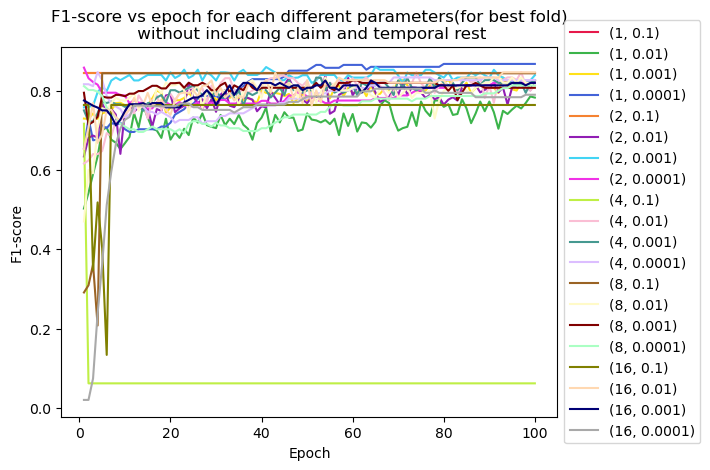

In [38]:
#By looking this graph we can say that which model gives a good f1-score. We are aware of that this plot not good at differentiate the every value.
#However, we are not using this graph to differentiate every value from the each other. Please note that we will explain the strange behaviour (90% f1-score lines ie.brown line)
fig = plt.figure()
ax = plt.axes()
x = np.arange(NO_EPOCH)+1

colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9', '#ffffff', '#000000']
best_idx_cvs = []
for idx in range(final_stat_s.shape[0]):
    best_idx_cvs.append(np.argmax(final_stat_s[idx][2]))
    ax.plot(x, epoch_stat_s[idx][2][best_idx_cvs[-1]], label=f'{combinations[idx]}',color=colors[idx]);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('F1-score vs epoch for each different parameters(for best fold)\n without including claim and temporal rest')
plt.xlabel("Epoch")
plt.ylabel("F1-score")

In [26]:
#Calculate mean result for the each different hyper parameter combination overall is 20
final_mean_s = np.mean(final_stat_s,axis=2)
print(f'Mean results for each combination(validation accuracy, training accuracy, f1 score, matthews_corrcoef):\n{final_mean_s}')

Mean results for each combination(validation accuracy, training accuracy, f1 score, matthews_corrcoef):
[[ 0.59968864  0.5         0.5220881  -0.0326965 ]
 [ 0.71772894  0.94811339  0.74441785  0.09106385]
 [ 0.79274725  0.98544818  0.79015584  0.11697103]
 [ 0.81194139  0.99471422  0.79906093  0.12912181]
 [ 0.70608059  0.5         0.63417588  0.        ]
 [ 0.77161172  0.99075892  0.77347939  0.07805497]
 [ 0.78503663  0.98822098  0.7889871   0.14222782]
 [ 0.78315018  0.98936684  0.782632    0.10489405]
 [ 0.14007326  0.5         0.03580806  0.        ]
 [ 0.77157509  0.98991098  0.77056822  0.05460504]
 [ 0.79653846  0.97975319  0.78478109  0.05798395]
 [ 0.76393773  0.97176871  0.76726435  0.05612201]
 [ 0.55608059  0.5         0.47639811  0.        ]
 [ 0.74467033  0.97024633  0.75280753  0.01701545]
 [ 0.79078755  1.          0.78937166  0.10668594]
 [ 0.72937729  0.94805899  0.749361    0.05187575]
 [ 0.39838828  0.5         0.31158511  0.        ]
 [ 0.79269231  0.99971989  0.

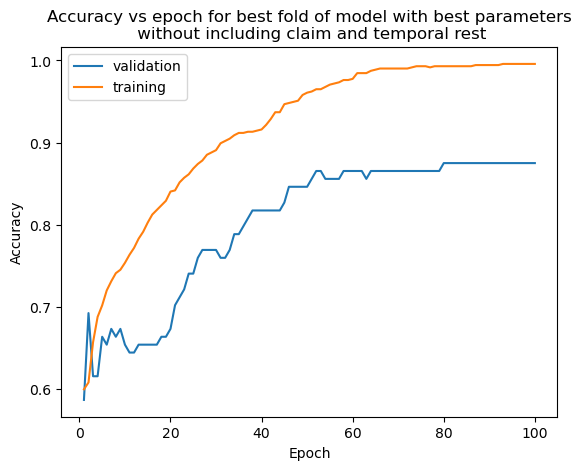

In [27]:
#we are selecting the overall best model by looking the graph
overall_best_s =3
#We are ploting the best fold result with the best parameters
fig = plt.figure()
ax = plt.axes()
#found best fold result
best_val_s =np.argmax(final_stat_s[overall_best_s][0])
y_v = epoch_stat_s[overall_best_s][0][best_val_s]
y_t = epoch_stat_s[overall_best_s][1][best_val_s]
x = np.arange(len(y_v))+1

ax.plot(x, y_v, label='validation');
ax.plot(x, y_t, label='training');

plt.title('Accuracy vs epoch for best fold of model with best parameters\n without including claim and temporal rest')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

***Explanation: Example of on of the straight f1-score lines.This is for the brown line.*** 

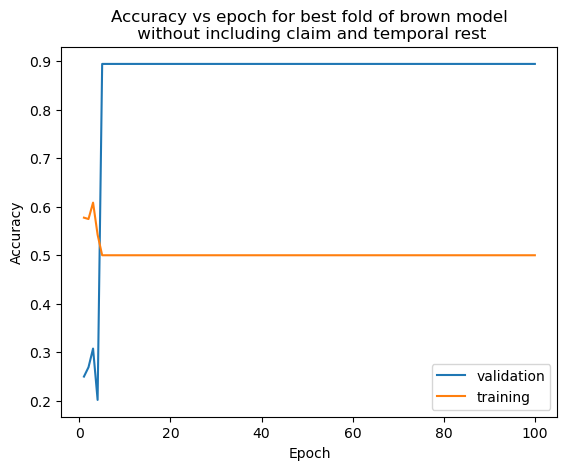

In [30]:
fig = plt.figure()
ax = plt.axes()
best_val_s =np.argmax(final_stat_s[12][2])
y_v = epoch_stat_s[12][0][best_val_s]
y_t = epoch_stat_s[12][1][best_val_s]
x = np.arange(len(y_v))+1

ax.plot(x, y_v, label='validation');
ax.plot(x, y_t, label='training');

plt.title('Accuracy vs epoch for best fold of brown model\n without including claim and temporal rest')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

This network is basically a  network that gives 0 everytime. The network is stuck to 50 accuracy for the training set. And we are balancing the data with smote (50% class 0 and 50% class 1), every time give all zeros wont change the loss value and model will stay at the same point.

Note that we are not balancing the validation data with smote(most of the validation set is 0) so this anomaly occurs.

In [31]:
#Calculate the best epoch result
maxIndx_s = np.argmax(epoch_stat_s[overall_best_s][0][best_val_s])

In [32]:
print(f"Our best result epoch(#{maxIndx_s})(validation accuracy, training accuracy, f1 score, matthews_corrcoef):{epoch_stat_s[overall_best_s,:,best_val_s,maxIndx_s]}")

Our best result epoch(#90)(validation accuracy, training accuracy, f1 score, matthews_corrcoef):[0.80769231 0.9971831  0.81465998 0.05908581]


In [33]:
print(f"Our mean result(validation accuracy, training accuracy, f1 score, matthews_corrcoef):{np.amax(final_mean_s, axis=0)}")

Our mean result(validation accuracy, training accuracy, f1 score, matthews_corrcoef):[0.81194139 1.         0.79906093 0.14222782]


Text(0, 0.5, 'F1-score')

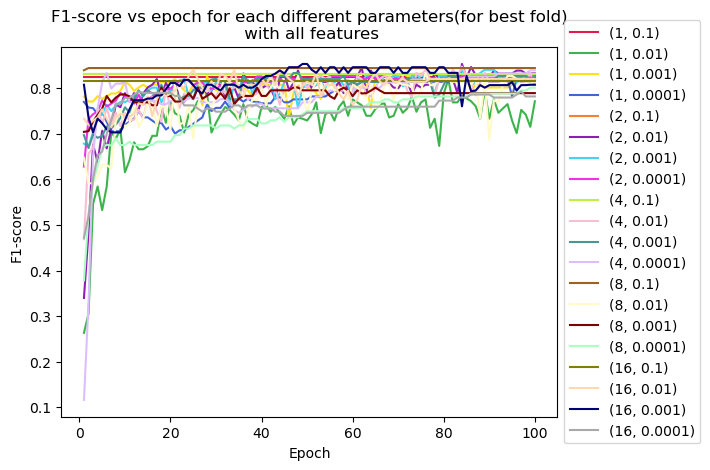

In [36]:
#By looking this graph we can say that which model gives a good accuracy. We are aware of that this plot not good at differentiate the every value.
#However, we are not using this graph to differentiate every value from the each other. Excluding straight lines using the same reasoning that is explained before.
fig = plt.figure()
ax = plt.axes()
x = np.arange(NO_EPOCH)+1

colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9', '#ffffff', '#000000']
best_idx_cvs = []
for idx in range(final_stat_s.shape[0]):
    best_idx_cvs.append(np.argmax(final_stat_e[idx][2]))
    ax.plot(x, epoch_stat_e[idx][2][best_idx_cvs[-1]], label=f'{combinations[idx]}',color=colors[idx]);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('F1-score vs epoch for each different parameters(for best fold)\n with all features')
plt.xlabel("Epoch")
plt.ylabel("F1-score")

In [35]:
#Calculate mean result for the each different hyper parameter combination overall is 20
final_mean_e = np.mean(final_stat_e,axis=2)
print(f'Mean results for each combination(validation accuracy, training accuracy, f1 score, matthews_corrcoef):\n{final_mean_e}')

Mean results for each combination(validation accuracy, training accuracy, f1 score, matthews_corrcoef):
[[ 0.70031136  0.5         0.62971656 -0.00711718]
 [ 0.72161172  0.9654629   0.73954937  0.00207676]
 [ 0.77734432  0.99888889  0.77561811  0.06028804]
 [ 0.77153846  0.99776442  0.77228368  0.0558397 ]
 [ 0.44391941  0.5         0.35490236  0.        ]
 [ 0.77738095  0.97398015  0.78123732  0.11057242]
 [ 0.76197802  0.99528069  0.7676754   0.05019313]
 [ 0.77357143  0.99387142  0.77415824  0.06301681]
 [ 0.44391941  0.5         0.35490236  0.        ]
 [ 0.75813187  0.97013239  0.76772899  0.08475486]
 [ 0.78509158  0.99944444  0.78403386  0.1000147 ]
 [ 0.76393773  0.98603495  0.77216518  0.09282096]
 [ 0.58684982  0.5         0.50576805  0.        ]
 [ 0.78117216  0.99832942  0.77731333  0.06073263]
 [ 0.76003663  0.99944516  0.76418622  0.03169973]
 [ 0.75043956  0.96731883  0.76524205  0.09621166]
 [ 0.55031136  0.50056259  0.47320362  0.00677745]
 [ 0.77728938  0.99887324  0.

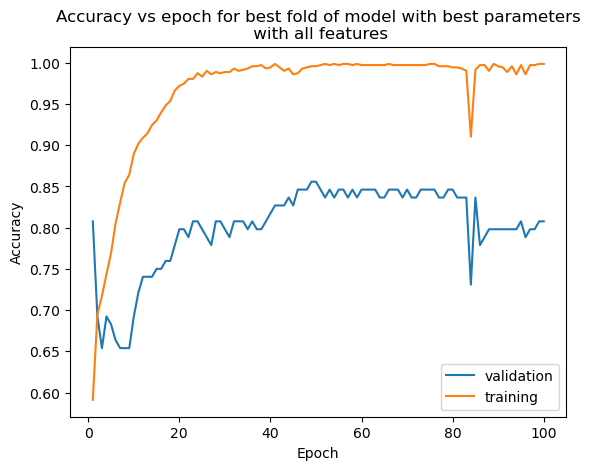

In [37]:
#we are selecting the overall best model by looking the graph(excluding straight lines)
overall_best_e = 18
#We are ploting the best fold result with the best parameters
fig = plt.figure()
ax = plt.axes()
#found best fold result
best_val_e =np.argmax(final_stat_e[overall_best_e][0])
y_v = epoch_stat_e[overall_best_e][0][best_val_e]
y_t = epoch_stat_e[overall_best_e][1][best_val_e]
x = np.arange(len(y_v))+1

ax.plot(x, y_v, label='validation');
ax.plot(x, y_t, label='training');

plt.title('Accuracy vs epoch for best fold of model with best parameters\n with all features')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [39]:
#Calculate the best epoch result
maxIndx_e = np.argmax(epoch_stat_e[overall_best_e][0][best_val_e])

In [41]:
print(f"Our best result epoch(#{maxIndx_e})(validation accuracy, training accuracy, f1 score, matthews_corrcoef):{epoch_stat_e[overall_best_e,:,best_val_e,maxIndx_e]}")

Our best result epoch(#48)(validation accuracy, training accuracy, f1 score, matthews_corrcoef):[0.85576923 0.99579832 0.85327869 0.31851103]


In [42]:
print(f"Our mean result(validation accuracy, training accuracy, f1 score, matthews_corrcoef):{np.amax(final_mean_e, axis=0)}")

Our mean result(validation accuracy, training accuracy, f1 score, matthews_corrcoef):[0.78509158 0.99944516 0.78403386 0.11057242]


***Recurrent Neural Network(Experimental)***

We experimented the RNN and we see that it does not work as we wanted so we experiment on it. Here the feature extraction is different from what we did before. This is just for experiment. We are including both friendship games and betrayal games. We are not excluding any game according to lasted friendship. We are just exclude the seasons that does not have any messages from both parties. We are labelling seasons 1 if it is the last season and if there is a betrayal, otherwise 0.

In [37]:
items = []
victim_items = []
betrayer_items = []
labels = []


for entry in diplomacy:
    
    seasons = seasons_before_betrayal(entry)
    vic_game = []
    bet_game = []
    label_game = []
    for i,season in enumerate(seasons):
        
        if len(season['messages']['victim']) == 0 or len(season['messages']['betrayer']) == 0:
            continue
        if len(seasons) == i+1 and entry["betrayal"]:
            label_item = 1
        else:
            label_item = 0
        label_game.append(label_item)
        for who in ["victim","betrayer"]:
            #politness
            politness = [message["politeness"] for message in season["messages"][who]]           
            politness_item = np.mean(politness) if len(politness)>=1 else 0
            #sentiment
            positive_sentiment = [message["sentiment"]["positive"] for message in season["messages"][who]]
            negative_sentiment = [message["sentiment"]["negative"] for message in season["messages"][who]]
            neutral_sentiment = [message["sentiment"]["neutral"] for message in season["messages"][who]]
            positive_item = np.mean(positive_sentiment) if len(positive_sentiment)>=1 else 0
            negative_item = np.mean(negative_sentiment) if len(negative_sentiment)>=1 else 0
            neutral_item = np.mean(neutral_sentiment) if len(neutral_sentiment)>=1 else 0
            #nb_requests
            nb_requests = [message["n_requests"] for message in season["messages"][who]]
            requests_item = np.mean(nb_requests) if len(nb_requests)>=1 else 0
            #nb_words
            nb_words = [message["n_words"] for message in season["messages"][who]]
            words_item = np.mean(nb_words) if len(nb_words)>=1 else 0
            #nb_sentences
            nb_sentences = [message["n_sentences"] for message in season["messages"][who]]
            sentences_item = np.mean(nb_sentences) if len(nb_sentences)>=1 else 0
            #premise
            premise = [len(message["lexicon_words"]["premise"]) for message in season["messages"][who] if "premise" in message["lexicon_words"].keys()]
            premise_item = np.mean(premise) if len(premise)>=1 else 0
            #claim
            claim = [len(message["lexicon_words"]["claim"]) for message in season["messages"][who] if "claim" in message["lexicon_words"].keys()]
            claim_item = np.mean(claim) if len(claim)>=1 else 0
            #disc_comparison
            disc_comparison = [len(message["lexicon_words"]["disc_comparison"]) for message in season["messages"][who] if "disc_comparison" in message["lexicon_words"].keys()]
            comparison_item = np.mean(disc_comparison) if len(disc_comparison)>=1 else 0
            #disc_expansion
            disc_expansion = [len(message["lexicon_words"]["disc_expansion"]) for message in season["messages"][who] if "disc_expansion" in message["lexicon_words"].keys()]
            expansion_item = np.mean(disc_expansion) if len(disc_expansion)>=1 else 0
            #disc_contingency
            disc_contingency = [len(message["lexicon_words"]["disc_contingency"]) for message in season["messages"][who] if "disc_contingency" in message["lexicon_words"].keys()]
            contingency_item = np.mean(disc_contingency) if len(disc_contingency)>=1 else 0
            #disc_temporal_future
            disc_temporal_future = [len(message["lexicon_words"]["disc_temporal_future"]) for message in season["messages"][who] if "disc_temporal_future" in message["lexicon_words"].keys()]
            temporal_future_item = np.mean(disc_temporal_future) if len(disc_temporal_future)>=1 else 0
            #disc_temporal_rest
            disc_temporal_rest = [len(message["lexicon_words"]["disc_temporal_rest"]) for message in season["messages"][who] if "disc_temporal_rest" in message["lexicon_words"].keys()]
            temporal_rest_item = np.mean(disc_temporal_rest) if len(disc_temporal_rest)>=1 else 0
            
            item = [politness_item,positive_item,negative_item,neutral_item,requests_item,words_item,sentences_item,\
                    premise_item,claim_item,comparison_item,expansion_item,contingency_item,temporal_future_item,temporal_rest_item]
            
            if who == "victim":
                vic_game.append(item)
            else:
                bet_game.append(item)
          
            
    if len(vic_game) != 0:
        victim_items.append(vic_game)
        betrayer_items.append(bet_game)
        labels.append(label_game)

We need successive seasons information in order to feed it into an RNN.

We manage that by creating a list of list and then transforming into an array of objects.

In [38]:
#Transformation from lists to numpy arrays
betrayer_feature = np.array(betrayer_items, dtype=object)
betrayer_feature = np.expand_dims(betrayer_feature, axis = 1)

victim_feature = np.array(victim_items,dtype=object)
victim_feature = np.expand_dims(victim_feature, axis = 1)

features =np.concatenate((betrayer_feature,victim_feature), axis =1)
labels = np.array(labels, dtype=object)

In [39]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.hidden_size = 64
        self.input_size = 28
        
        #Simply two linear layers that uses the hidden layer as part of their input
        self.hidden_layer = nn.Linear(self.input_size + self.hidden_size, self.hidden_size)
        self.output_layer = nn.Linear(self.input_size + self.hidden_size, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        x = x.view(1,-1)
        combined = torch.cat((x, hidden), 1).cuda()
        hidden = self.hidden_layer(combined)
        output = self.output_layer(combined)
        output = self.softmax(output)
        return output, hidden
    
    #Initialize the hidden layer to all zeros
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [40]:
if cuda_is_available:
    model = RNN().cuda()
else:
    model = RNN()

In [41]:
#Create a balance array where the number corrsespond to how much the class at that index should be amplified in weight.
#In our case, 0 labels are untouched and 1 labels are weighted almost 10 times
temp = np.array((1,9.713178294573643 ))
balance = torch.from_numpy(temp)

In [42]:
#Specifiy the training hyper-parameters such as the loss function, learning rate and the optimizer
criterion = nn.CrossEntropyLoss(weight = balance.float().cuda())
optimizer = optim.Adam(model.parameters(), lr=0.001)#, weight_decay=1e-6)

In [43]:
def train_model_rnn(input_label_size,model, org_labels, org_features, no_epoch, optimizer, criterion, verbose = True):
    model.train()
    for epoch in range(NO_EPOCH):  # loop over the dataset multiple times
        running_loss = 0.0
        k = 0
        
        # Shuffle the dataset and seperate it into training and test set.
        rand_idx=np.random.permutation(len(org_features))
        features = org_features[rand_idx]
        labels = np.array(org_labels)[rand_idx]
        train_features = features[0:200]
        train_labels = labels[0:200]
        
        
        test_features = features[200:-1]
        test_labels = labels[200:-1]
        #Performed for each game in the training set
        for i in range(len(train_features)):
            
            ft_1 = np.array(train_features[i,0])      
            ft_2 = np.array(train_features[i,1])
            ft = np.concatenate(( (ft_1 +ft_2) /2.0 ,np.absolute(ft_1 - ft_2)), axis=1)
            lb =  np.array(train_labels[i])           
            
            if cuda_is_available:
                sample = torch.from_numpy(ft).float().cuda()
                target = torch.from_numpy(lb).long().cuda()
                
            # zero the parameter gradients
            optimizer.zero_grad()
            
            hidden = model.initHidden().cuda()
            
            # Forward pass and calculate the loss
            for j in range(sample.shape[0]):
                truth = target[j].view(1)
                #Calculate the running mean for the season
                current_sample = torch.mean(sample[0:j+1],axis = 0)
                out,hidden = model(current_sample.view(1,-1),hidden)
                loss = criterion(out, truth)

            # Backward pass + optimize
            loss.backward(retain_graph=True)
            optimizer.step()
            hidden = hidden.detach()

           # print statistics
            if verbose:
                running_loss += loss.item()
                if k % 100 == 99:
                    print('[%d, %5d] loss: %f' %
                          (epoch + 1, k, running_loss/100))
                    running_loss = 0.0
                k += 1
    
        #validation
        model.eval()
        preds = []
        accuracy_v = []
        matthews_corrcoefs = []
        f1_scores = []
        #Perfrom the same forward pass without calculating gradients
        with torch.no_grad():
            hidden = model.initHidden().cuda()
            for i in range(len(test_features)):
                ft_1 = np.array(test_features[i,0])      
                ft_2 = np.array(test_features[i,1])
                ft = np.concatenate(( (ft_1 +ft_2) /2.0 ,np.absolute(ft_1 - ft_2)), axis=1)
                lb =  np.array(test_labels[i])

                sample = torch.from_numpy(ft).float().cuda()
                target = torch.from_numpy(lb).long().cuda()
                
                hidden = model.initHidden().cuda()
                
                # forward + backward + optimize
                for j in range(sample.shape[0]):
                    truth = target[j].view(1)
                    #Calculate the running mean for the season
                    current_sample = torch.mean(sample[0:j+1],axis = 0)
                    out,hidden = model(current_sample.view(1,-1),hidden)
                    
                    prediction_v = predict_label_rnn(out)
                    #print(prediction_v)
                    accuracy_v.append(np.mean(prediction_v == truth.detach().cpu().numpy()))
                    matthews_corrcoefs.append(matthews_corrcoef(truth.detach().cpu().numpy(), prediction_v))
                    f1_scores.append(f1_score(truth.detach().cpu().numpy(), prediction_v, average='weighted'))

    print('Finished Training')
    return np.mean(np.array(accuracy_v)) ,np.mean(np.array(f1_scores)),np.mean(np.array(matthews_corrcoefs))

In [44]:
def predict_label_rnn(output):
    output = output.detach().cpu().numpy()
    return np.array([1 if label[1]>=label[0] else 0 for label in output ])

In [45]:
mean_accuracy,mean_f1_score, mean_matthews_corrcoef = train_model_rnn(24,model, labels, features, NO_EPOCH,optimizer,criterion)

[1,    99] loss: 1.182764
[1,   199] loss: 0.994846
[2,    99] loss: 0.974633
[2,   199] loss: 0.817621
[3,    99] loss: 0.867998
[3,   199] loss: 0.915052
[4,    99] loss: 0.947105
[4,   199] loss: 0.840241
[5,    99] loss: 0.670109
[5,   199] loss: 0.781437
[6,    99] loss: 0.697694
[6,   199] loss: 0.793016
[7,    99] loss: 0.777367
[7,   199] loss: 0.992036
[8,    99] loss: 0.849156
[8,   199] loss: 0.669905
[9,    99] loss: 0.725323
[9,   199] loss: 0.707600
[10,    99] loss: 0.614473
[10,   199] loss: 0.738845
Finished Training


In [46]:
print(f'Accuracy: {mean_accuracy}, F1-score:{mean_f1_score}, Matthews correlation coefficient: {mean_matthews_corrcoef}')

Accuracy: 0.7625570776255708, F1-score:0.7625570776255708, Matthews correlation coefficient: 0.0
